# 0. Imports

In [1]:
import os

import pandas as pd
import numpy as np

import torch
import torch.nn as nn ## torch.nn gives us nn.Module(), nn.Embedding() and nn.Linear()
import torch.nn.functional as F # This gives us the softmax() and argmax()
from torch.optim import Adam 
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo disponível: {device}")

import warnings
warnings.filterwarnings("ignore")

Dispositivo disponível: cuda


In [2]:
# Define a function to pad sequences to a specified length
def pad_sequences(sequences, max_len, pad_token):
    padded_sequences = []
    for seq in sequences:
        if len(seq) < max_len:
            seq.extend([pad_token] * (max_len - len(seq)))
        padded_sequences.append(seq)
    return padded_sequences

# 1. Dataset

In [3]:
# get always the right paths even if the code is ran in another computer
directory = os.getcwd()
current_directory = os.path.dirname(directory)

# import datafrae
df = pd.read_excel(current_directory+"\\1_Data\\Porto_DB.xlsx").drop(columns=["Unnamed: 0"],axis=1)[:11]

# add allways and EOS (End of Sentence) token at the end of each text
df["Final"] = df["Final"].apply(lambda x: x+" <EOS>")

df.head()

,Final
0,The Porto Tram Museum (Museu do Carro Eléctric...
1,The rabelo boat is a traditional Portuguese wo...
2,STCP (Sociedade de Transportes Colectivos do P...
3,The tram system of Porto in Portugal is operat...
4,"The FC Porto Museum, officially known as FC Po..."


# 2. Tokenizer

## 2.1. Data to Tokenize

In [4]:
# prepare the dataframe to create the tokens
df_token = '\n'.join(df.astype(str).apply(lambda x: ' '.join(x), axis=1))
df_token


'The Porto Tram Museum (Museu do Carro Eléctrico) is a museum operated by the Sociedade de Transportes Colectivos do Porto. It was inaugurated in 1992 and is installed in a former thermoelectric power station next to the River Douro in Massarelos, Porto, Portugal. It exhibits material related to the history of trams in Porto. The collection contains 16 electric cars, 5 trailers, and two maintenance vehicles as well as the former equipment of the power plant, which provided electricity for the tram lines.\n\n\n== The building ==\nThe construction of the building as a power plant was completed in 1915. It consists of two large halls that were, respectively, the hall for the steam generators (boilers) and the engine room. Until the 1940s the power station produced enough energy to power the tram network. However, with the increase in the number of electric cars in circulation, the trams became partially dependent on the city\'s power supply and in the 1960s energy production at the plant 

In [5]:
# create unique tokens
tokens = df_token.split()
unique_tokens = set([token.lower() for token in tokens])

# create the index to each token
tokens_to_id = {token: idx for idx, token in enumerate(unique_tokens)}

# Add these special tokens
tokens_to_id['<PAD>'] = len(tokens_to_id)
tokens_to_id['<EOS>'] = len(tokens_to_id)

id_to_token = dict(map(reversed, tokens_to_id.items()))


In [6]:
# Initialize lists for inputs and outputs
inputs = []
labels = []

for t in range(df.shape[0]):
        inputs.append(df.iloc[t][0].split()[:-1])
        labels.append(df.iloc[t][0].split()[1:])


final_inputs = []
final_labels = []

# Process each line to split into input and output
for inp, out in zip(inputs, labels):        
        tokenized_input = [ tokens_to_id[token.lower()] if token != '<EOS>' else tokens_to_id[token] for token in inp]
        final_inputs.append(tokenized_input)
        tokenized_labels = [tokens_to_id[token.lower()] if token != '<EOS>' else tokens_to_id[token] for token in out]
        final_labels.append(tokenized_labels)

padded_inputs = pad_sequences(final_inputs, 700, tokens_to_id['<PAD>'])
padded_labels = pad_sequences(final_labels, 700, tokens_to_id['<PAD>'])

# Convert to tensors
inputs = torch.tensor(final_inputs, dtype=torch.int64)
labels = torch.tensor(final_labels, dtype=torch.int64)

# 3. Batch

In [7]:
max_len=3000 #input size
vocab_size = len(tokens_to_id) 
d_model=800 # embeddings dimension
max_length = 20 # output size

# 4. DataLoader - Prepare Dataset for Training

In [8]:
dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset)

# 5. Embeddings

## 5.1. Class

In [9]:
class Embeddings(nn.Module):
    def __init__(self,vocab_size=vocab_size, d_model=d_model):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        embeddings = self.embeddings(x)
        return embeddings

## 5.2. Test Class

In [10]:
embeddings = Embeddings()
emb = embeddings(inputs[0])
emb

tensor([[ 0.9134,  0.6272, -0.5782,  ..., -0.2361, -0.8807,  0.8350],
        [-0.7854, -1.3265,  0.6188,  ...,  0.0990, -0.3297, -0.6618],
        [-1.0204,  1.1756,  2.3574,  ...,  0.2662,  0.7856, -0.2194],
        ...,
        [-0.4338,  1.3702,  0.5727,  ..., -0.4898,  1.4387,  1.1450],
        [-0.4338,  1.3702,  0.5727,  ..., -0.4898,  1.4387,  1.1450],
        [-0.4338,  1.3702,  0.5727,  ..., -0.4898,  1.4387,  1.1450]],
       grad_fn=<EmbeddingBackward0>)

# 6. Positional Encodings

## 6.1. Class

In [11]:
class PositionEncoding(nn.Module):
    
    def __init__(self, d_model=d_model, max_len=max_len):        
        super().__init__()
       
        pe = torch.zeros(max_len, d_model)  
        position = torch.arange(start=0, end=max_len, step=1).float().unsqueeze(1)

        embedding_index = torch.arange(start=0, end=d_model, step=2).float()
        
        div_term = 1/torch.tensor(10000.0)**(embedding_index / d_model)
        
        pe[:, 0::2] = torch.sin(position * div_term) ## every other column, starting with the 1st, has sin() values
        pe[:, 1::2] = torch.cos(position * div_term) ## every other column, starting with the 2nd, has cos() values
      
        ## Now we "register 'pe'.
        self.register_buffer('pe', pe) ## "register_buffer()" ensures that
                                       ## 'pe' will be moved to wherever the model gets
                                       ## moved to. So if the model is moved to a GPU, then,
                                       ## even though we don't need to optimize 'pe', it will 
                                       ## also be moved to that GPU. This, in turn, means
                                       ## that accessing 'pe' will be relatively fast copared
                                       ## to having a GPU have to get the data from a CPU.

    def forward(self, word_embeddings):
        # print(word_embeddings.size())
        # print(self.pe[:word_embeddings.size(0), :].size())#[:word_embeddings.size(0), :])
        return word_embeddings.to(device) + self.pe[:word_embeddings.size(0), :].to(device) ## word_embeddings.size(0) = number of embeddings
                                                                      ## NOTE: That second ':' is optional and 
                                                                      ## we could re-write it like this: 
                                                                      ## self.pe[:word_embeddings.size(0)]

## 6.2. Test Class

In [12]:
PE = PositionEncoding()
pe_embeddings = PE(emb)
pe_embeddings

tensor([[ 0.9134,  1.6272, -0.5782,  ...,  0.7639, -0.8807,  1.8350],
        [ 0.0560, -0.7862,  1.4478,  ...,  1.0990, -0.3296,  0.3382],
        [-0.1111,  0.7595,  3.2846,  ...,  1.2662,  0.7858,  0.7806],
        ...,
        [-0.8539,  2.2777,  1.1301,  ...,  0.5075,  1.5100,  2.1425],
        [ 0.1029,  2.2140,  0.1963,  ...,  0.5075,  1.5101,  2.1425],
        [ 0.5662,  1.3746, -0.4058,  ...,  0.5075,  1.5102,  2.1425]],
       device='cuda:0', grad_fn=<AddBackward0>)

# 7. Self-Attention

## 7.1. Class

In [13]:
class Attention(nn.Module): 
    
    def __init__(self, d_model=d_model):     
        super().__init__()
        
        self.d_model=d_model
        self.W_q = nn.Linear(in_features=d_model, out_features=d_model, bias=False)
        self.W_k = nn.Linear(in_features=d_model, out_features=d_model, bias=False)
        self.W_v = nn.Linear(in_features=d_model, out_features=d_model, bias=False)
        
        self.row_dim = 0
        self.col_dim = 1
        
    def forward(self, pos_embeddings_q, pos_embeddings_k, pos_embeddings_v, mask=None):
        
        q = self.W_q(pos_embeddings_q)
        k = self.W_k(pos_embeddings_k)
        v = self.W_v(pos_embeddings_v)
        
        sims = torch.matmul(q, k.transpose(dim0=self.row_dim, dim1=self.col_dim))

        scaled_sims = sims / torch.tensor(k.size(self.col_dim)**0.5).to(device)

        if mask is not None:
            scaled_sims = scaled_sims.masked_fill(mask=mask.to(device), value=-1e9) 
        
        attention_percents = F.softmax(scaled_sims, dim=self.col_dim)

        # Scale the values by their associated percentages and add them up.
        attention_scores = torch.matmul(attention_percents, v)
        
        return attention_scores.to(device)

## 7.2. Test Class

In [14]:
attention = Attention().to(device)
attention(pe_embeddings,pe_embeddings,pe_embeddings)

tensor([[ 2.4143e-03,  5.2457e-01, -1.7800e-01,  ...,  2.8923e-01,
         -8.3823e-02, -7.3993e-02],
        [ 2.0406e-03,  5.3778e-01, -1.9948e-01,  ...,  2.4506e-01,
         -1.2755e-01, -5.7603e-02],
        [-3.5603e-04,  5.2020e-01, -1.6711e-01,  ...,  2.7922e-01,
         -5.8772e-02, -7.3651e-02],
        ...,
        [-2.1037e-04,  5.2779e-01, -1.3277e-01,  ...,  1.9884e-01,
         -1.4971e-01, -6.9328e-02],
        [-1.6511e-03,  5.2060e-01, -1.2263e-01,  ...,  1.9627e-01,
         -1.4850e-01, -6.8570e-02],
        [-1.8317e-03,  5.1860e-01, -1.1625e-01,  ...,  1.9706e-01,
         -1.4519e-01, -6.1325e-02]], device='cuda:0', grad_fn=<MmBackward0>)

# 8. DecoderOnlyTransformer

## 8.1 Class

In [15]:
torch.manual_seed(0)

class DecoderOnlyTransformer(nn.Module):
    
    def __init__(self, vocab_size=vocab_size, d_model=d_model, max_len=max_len):
        
        super().__init__()
        
        self.we = Embeddings(vocab_size, d_model)     
        
        self.pe = PositionEncoding(d_model=d_model, 
                                   max_len=max_len)

        self.self_attention = Attention(d_model=d_model)

        self.fc_layer = nn.Linear(in_features=d_model, out_features=vocab_size)
        
        self.loss = nn.CrossEntropyLoss()
        
        
    def forward(self, token_ids):
                
        word_embeddings = self.we(token_ids)     
        pe_embeddings = self.pe(word_embeddings)
        
        mask = torch.tril(torch.ones((token_ids.size(dim=0), token_ids.size(dim=0))))
        mask = mask == 0
        
        self_attention_values = self.self_attention(pe_embeddings, 
                                                    pe_embeddings, 
                                                    pe_embeddings, 
                                                    mask=mask)
        
        residual_connection_values = pe_embeddings + self_attention_values
        
        fc_layer_output = self.fc_layer(residual_connection_values)
        
        return fc_layer_output


## 8.2. Test Class

In [16]:
model = DecoderOnlyTransformer(vocab_size=len(tokens_to_id), d_model=d_model, max_len=max_len).to(device)

prompt = "The Porto Tram Museum (museu do carro eléctrico)"
prompt_listed = list(prompt.split())
for p in prompt_listed:
    prompt_tokenized = torch.tensor([tokens_to_id[token.lower()] for token in prompt_listed])


## Now get get predictions from the model
predictions = model(prompt_tokenized.to(device)) 
predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])

predicted_ids = predicted_id


for i in range(max_length):
    if (predicted_id == tokens_to_id["<EOS>"]): # if the prediction is <EOS>, then we are done
        break
    
    model_input = torch.cat((prompt_tokenized.to(device), predicted_id.to(device)))
    
    predictions = model(model_input) 
    predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])
    predicted_ids = torch.cat((predicted_ids, predicted_id))
        
## Now printout the predicted output phrase.
answer = []
for id in predicted_ids: 
    answer.append(id_to_token[id.item()])

" ".join(answer)

'lisbon, system. dragão. remainder truth. duarte newspaper companies, lisbon, system. dragão. remainder truth. duarte newspaper companies, lisbon, system. dragão. remainder truth.'

# 9. Treino

## 9.1. Batch - Treino

In [17]:
model = DecoderOnlyTransformer(vocab_size=len(tokens_to_id), d_model=d_model, max_len=max_len).to(device)
loss_fn = nn.CrossEntropyLoss(ignore_index=tokens_to_id['<PAD>'])
optimizer = Adam(model.parameters(), lr=0.0001)

## 9.2. Loop

Epoch 1/400, Loss: 7.56303501129150390625
Epoch 2/400, Loss: 7.10468482971191406250
Epoch 3/400, Loss: 6.59410619735717773438
Epoch 4/400, Loss: 6.15061664581298828125
Epoch 5/400, Loss: 5.75122642517089843750
Epoch 6/400, Loss: 5.38459348678588867188
Epoch 7/400, Loss: 5.04149866104125976562
Epoch 8/400, Loss: 4.70913076400756835938
Epoch 9/400, Loss: 4.39452171325683593750
Epoch 10/400, Loss: 4.08136463165283203125
Epoch 11/400, Loss: 3.82836794853210449219
Epoch 12/400, Loss: 3.53961491584777832031
Epoch 13/400, Loss: 3.25832509994506835938
Epoch 14/400, Loss: 2.99959588050842285156
Epoch 15/400, Loss: 2.77414178848266601562
Epoch 16/400, Loss: 2.52465939521789550781
Epoch 17/400, Loss: 2.33367156982421875000
Epoch 18/400, Loss: 2.14432859420776367188
Epoch 19/400, Loss: 1.97512388229370117188
Epoch 20/400, Loss: 1.82129895687103271484
Epoch 21/400, Loss: 1.69887971878051757812
Epoch 22/400, Loss: 1.59271788597106933594
Epoch 23/400, Loss: 1.48454499244689941406
Epoch 24/400, Loss: 

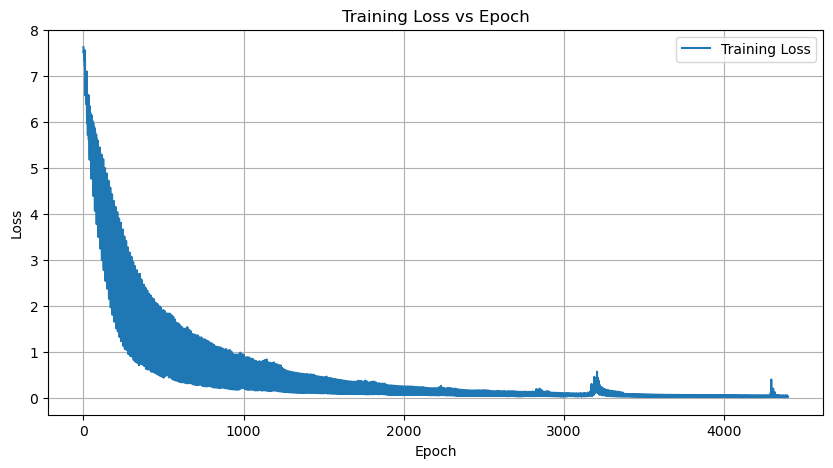

In [18]:
losses=[]
## Train the model
num_epochs = 400

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch in dataloader:
        inputs, labels = batch
        ## Forward pass
        outputs = model(inputs.squeeze(0).to(device))
        
        ## Compute the loss
        loss = loss_fn(outputs.to(device), labels.view(-1).to(device))
        
        ## Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.to("cpu").detach().numpy())

    if (epoch+1) % 1 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss/len(inputs):.20f}')
    elif loss<0.00000000001:
        break


plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [24]:
prompt = "The Porto Tram Museum (museu do carro eléctrico)"
prompt_listed = list(prompt.split())
for p in prompt_listed:
    prompt_tokenized = torch.tensor([tokens_to_id[token.lower()] for token in prompt_listed])


## Now get get predictions from the model
predictions = model(prompt_tokenized.to(device)) 
predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])
predicted_ids = predicted_id
max_length=800
for i in range(max_length):

    if (predicted_id == tokens_to_id["<EOS>"]): # if the prediction is <EOS>, then we are done
        break
    
    prompt_tokenized = torch.cat((prompt_tokenized, predicted_id))
    
    predictions = model(prompt_tokenized.to(device)) 
    predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])
    predicted_ids = torch.cat((predicted_ids, predicted_id))
        
## Now printout the predicted output phrase.
answer = []
for id in predicted_ids: 
    answer.append(id_to_token[id.item()])

print("Training Set: "+ "The Porto Tram Museum (Museu do Carro Eléctrico) is a museum operated by the Sociedade de Transportes Colectivos do Porto. It was inaugurated in 1992 and is installed \nin a former thermoelectric power station next to the River Douro in Massarelos, Porto, Portugal. It exhibits material related to the history of trams in Porto.")
print("--------------------")
print("Prompt: "+prompt)
print("--------------------")
print("Cahtbot Answer: "+" ".join(answer))

Training Set: The Porto Tram Museum (Museu do Carro Eléctrico) is a museum operated by the Sociedade de Transportes Colectivos do Porto. It was inaugurated in 1992 and is installed 
in a former thermoelectric power station next to the River Douro in Massarelos, Porto, Portugal. It exhibits material related to the history of trams in Porto.
--------------------
Prompt: The Porto Tram Museum (museu do carro eléctrico)
--------------------
Cahtbot Answer: is a museum operated by the sociedade de transportes colectivos do porto. it was inaugurated in 1992 and is installed in a former thermoelectric power station next to the river douro in massarelos, porto, portugal. it exhibits material related to the history of trams in porto. the collection contains 16 electric cars, 5 trailers, and two maintenance vehicles as well as the former equipment of the power plant, which provided electricity for the tram lines. == the building == the construction of the building as a power plant was completed 

# 10. Save the Model

In [20]:
model_path = current_directory+"\\3_SavedModel\\simple_model_checkpoint.pth"

In [21]:
checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
}
torch.save(checkpoint, model_path)

# 11. Load the Model

In [22]:
loaded_model = DecoderOnlyTransformer().to(device)
loaded_model.eval()  


checkpoint = torch.load(model_path)
loaded_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']
loss = checkpoint['loss']

# Confirme que os estados foram carregados corretamente
print(loaded_model)
print(optimizer)
print(f"Start epoch: {start_epoch}")
print(f"Loss: {loss}")

DecoderOnlyTransformer(
  (we): Embeddings(
    (embeddings): Embedding(1561, 800)
  )
  (pe): PositionEncoding()
  (self_attention): Attention(
    (W_q): Linear(in_features=800, out_features=800, bias=False)
    (W_k): Linear(in_features=800, out_features=800, bias=False)
    (W_v): Linear(in_features=800, out_features=800, bias=False)
  )
  (fc_layer): Linear(in_features=800, out_features=1561, bias=True)
  (loss): CrossEntropyLoss()
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
Start epoch: 399
Loss: 0.023381095379590988


## 11.1. Test Loaded Model

In [23]:
prompt = "The Porto Tram Museum (museu do carro eléctrico) is a museum operated"
prompt_listed = list(prompt.split())
for p in prompt_listed:
    prompt_tokenized = torch.tensor([tokens_to_id[token.lower()] for token in prompt_listed])


## Now get get predictions from the model
predictions = loaded_model(prompt_tokenized.to(device))
predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])
predicted_ids = predicted_id
max_length=1000
for i in range(max_length):

    if (predicted_id == tokens_to_id["<EOS>"]): # if the prediction is <EOS>, then we are done
        break
    
    prompt_tokenized = torch.cat((prompt_tokenized, predicted_id))
    
    predictions = loaded_model(prompt_tokenized.to(device)) 
    predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])
    predicted_ids = torch.cat((predicted_ids, predicted_id))
        
## Now printout the predicted output phrase.
answer = []
for id in predicted_ids: 
    answer.append(id_to_token[id.item()])

print("Training Set: "+ "The Porto Tram Museum (Museu do Carro Eléctrico) is a museum operated by the Sociedade de Transportes Colectivos do Porto. It was inaugurated in 1992 and is installed \nin a former thermoelectric power station next to the River Douro in Massarelos, Porto, Portugal. It exhibits material related to the history of trams in Porto.")
print("--------------------")
print("Prompt: "+prompt)
print("--------------------")
print("Cahtbot Answer: "+" ".join(answer))

Training Set: The Porto Tram Museum (Museu do Carro Eléctrico) is a museum operated by the Sociedade de Transportes Colectivos do Porto. It was inaugurated in 1992 and is installed 
in a former thermoelectric power station next to the River Douro in Massarelos, Porto, Portugal. It exhibits material related to the history of trams in Porto.
--------------------
Prompt: The Porto Tram Museum (museu do carro eléctrico) is a museum operated
--------------------
Cahtbot Answer: by the sociedade de transportes colectivos do porto. it was inaugurated in 1992 and is installed in a former thermoelectric power station next to the river douro in massarelos, porto, portugal. it exhibits material related to the history of trams in porto. the collection contains 16 electric cars, 5 trailers, and two maintenance vehicles as well as the former equipment of the power plant, which provided electricity for the tram lines. == the building == the construction of the building as a power plant was completed 